In [1]:
# !pip install pandas matplotlib numpy seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("Logs/episode_data.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 0 to 1076
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   episode_id           1077 non-null   int64  
 1   total_reward         1077 non-null   float64
 2   success              1077 non-null   int64  
 3   time_to_goal         1077 non-null   int64  
 4   visited_cells_count  1077 non-null   int64  
 5   distance_traveled    1077 non-null   float64
 6   maze_size            1077 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 59.0 KB


In [4]:
df.describe()

,episode_id,total_reward,success,time_to_goal,visited_cells_count,distance_traveled,maze_size
count,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000
mean,783.544104,0.403918,0.495822,2951.159703,40.113278,74.502634,9.397400
std,486.196400,1.659343,0.500215,4035.082721,40.564399,102.495444,2.962892
min,2.000000,-1.980000,0.000000,24.000000,2.000000,0.718000,5.000000
25%,349.000000,-1.130000,0.000000,560.000000,11.000000,14.756000,7.000000
50%,772.000000,0.790000,0.000000,1557.000000,26.000000,38.520000,9.000000
75%,1217.000000,2.060000,1.000000,3555.000000,56.000000,91.283000,11.000000
max,1642.000000,3.750000,1.000000,43531.000000,289.000000,1107.721000,15.000000


<Figure size 1600x1200 with 0 Axes>

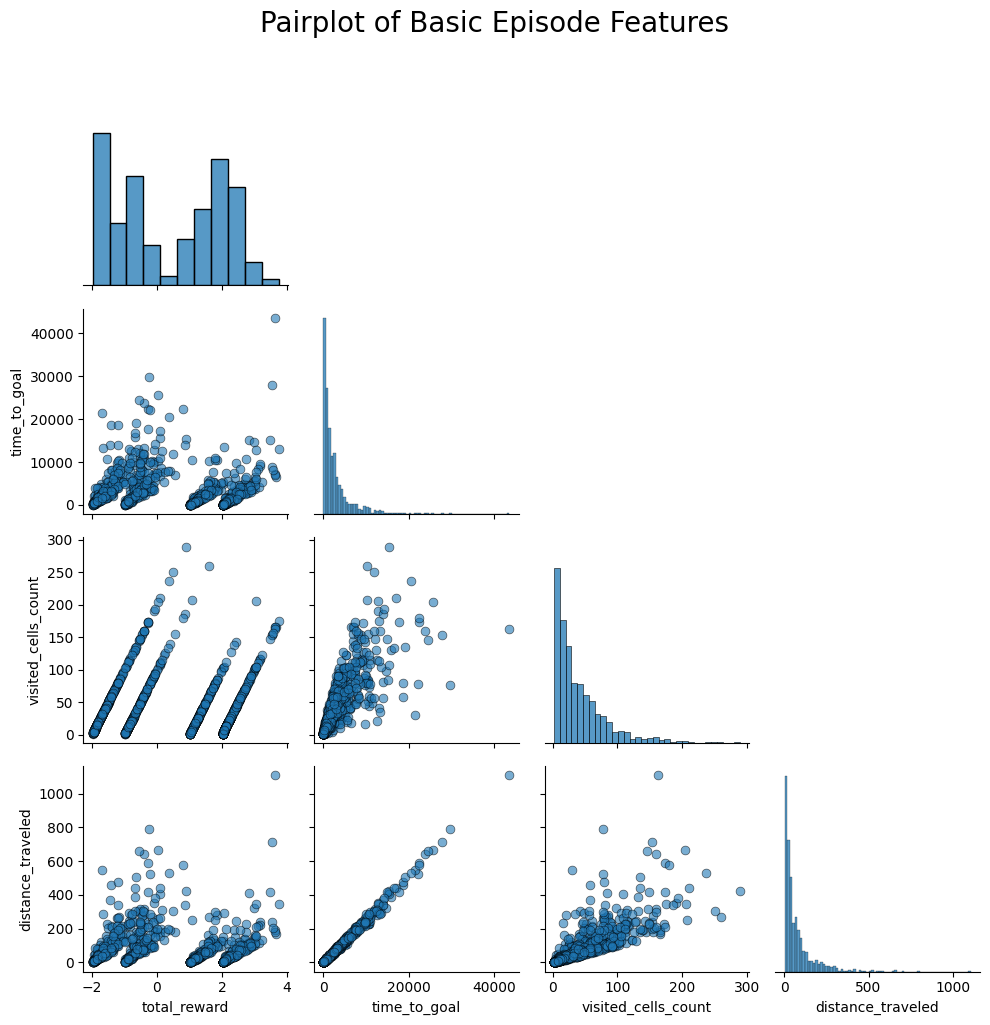

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))

base_features = ['total_reward', 'time_to_goal', 
                 'visited_cells_count', 'distance_traveled']

plot = sns.pairplot(
    df[base_features].sample(1000, random_state=42),
    corner=True,
    plot_kws={'alpha': 0.6, 's': 40, 'edgecolor': 'k'},
    diag_kws={'fill': True}
)

plot.fig.suptitle("Pairplot of Basic Episode Features", y=1.02, fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.show()


In [6]:
df['maze_size'].value_counts()

maze_size
7     238
9     230
13    200
11    190
5     159
15     60
Name: count, dtype: int64

In [7]:
df['normalized_coverage'] = df['visited_cells_count'] / (df['maze_size'] ** 2)


df['efficiency'] = df['total_reward'] / (df['distance_traveled'] + 1e-5)
df['reward_per_cell'] = df['total_reward'] / (df['visited_cells_count'] + 1e-5)
df['distance_per_cell'] = df['distance_traveled'] / (df['visited_cells_count'] + 1e-5)
df['log_maze_size'] = np.log(df['maze_size'])


features = ['total_reward', 'visited_cells_count', 'distance_traveled', 'normalized_coverage', 'efficiency', 'reward_per_cell', 'distance_per_cell','log_maze_size', 'maze_size']

df = df[features + ['episode_id']].copy()

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])


iso = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso.fit_predict(X_scaled)


df = df[outlier_labels == 1].reset_index(drop=True)


df.describe()

,total_reward,visited_cells_count,distance_traveled,normalized_coverage,efficiency,reward_per_cell,distance_per_cell,log_maze_size,maze_size,episode_id
count,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000
mean,0.397107,38.048876,64.279195,0.465991,0.048280,0.037735,1.566203,2.186389,9.379277,783.175953
std,1.650642,35.326345,72.586620,0.392942,0.217605,0.211301,0.850183,0.330164,2.924497,485.663089
min,-1.970000,2.000000,1.093000,0.011834,-0.896607,-0.656664,0.413332,1.609438,5.000000,2.000000
25%,-1.130000,11.500000,15.186500,0.148039,-0.023350,-0.036512,1.051058,1.945910,7.000000,350.000000
50%,1.020000,26.000000,37.567000,0.358025,0.005969,0.016993,1.332199,2.197225,9.000000,766.000000
75%,2.070000,54.000000,86.369500,0.680000,0.061840,0.081429,1.810758,2.397895,11.000000,1218.500000
max,3.660000,207.000000,521.155000,2.081633,1.319390,1.009995,9.077606,2.708050,15.000000,1642.000000


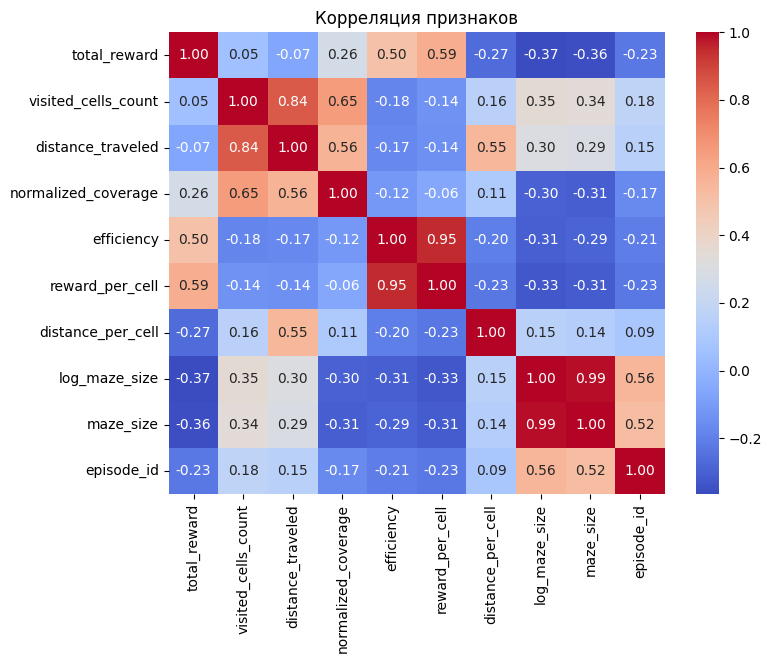

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляция признаков')
plt.show()

In [9]:
def assign_size_group(size):
    if size < 9:
        return 'small'
    elif size < 13:
        return 'medium'
    else:
        return 'large'

df['size_group'] = df['maze_size'].apply(assign_size_group)
df_small = df[df['size_group'] == 'small'].copy()
df_medium = df[df['size_group'] == 'medium'].copy()
df_large = df[df['size_group'] == 'large'].copy()

In [10]:
features = ['efficiency', 'reward_per_cell', 'distance_per_cell', 'distance_traveled']

X1 = df_small[features].copy()
X2 = df_medium[features].copy()
X3 = df_large[features].copy()

scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.fit_transform(X2)
X3_scaled = scaler.fit_transform(X3)


In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

def plot_clusters(X, labels, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=15)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [12]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score



def evaluate_davies_bouldin(X, labels):
    unique_labels = set(labels)
    if len(unique_labels) <= 1 or (len(unique_labels) == 2 and -1 in unique_labels):
        return None
    try:
        score = davies_bouldin_score(X, labels)
        return {
            "score": score,
            "labels": labels
        }
    except ValueError:
        return None




def find_best_n_clusters(X, method_name, clusterer_func, cluster_range=range(3, 7), min_cluster_size=20):
    best_result = None
    best_score = float('inf')
    

    for n in cluster_range:
        try:
            model = clusterer_func(n)
            labels = model.fit_predict(X)

            unique_labels, counts = np.unique(labels, return_counts=True)
            if np.any(counts < min_cluster_size):
                continue

            metrics = evaluate_davies_bouldin(X, labels)
            
            
            if metrics:
                score = metrics["score"]
                if score < best_score:
                    best_score = score
                    best_result = {
                        "n": n,
                        "method": method_name,
                        "score": score,
                        "labels": labels
                    }
        except:
            continue

    if best_result is None:
        return {
            "n": None,
            "method": method_name,
            "score": None,
            "labels": None
        }

    return best_result

In [13]:
def run_dbscan_with_grid_search(X, max_clusters=7):
    best_result = None
    best_score = float('inf')
    

    eps_values = np.arange(0.2, 1.0, 0.1)
    min_samples_values = range(20, 35, 5)

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters < 3 or n_clusters > max_clusters:
                continue


            result = evaluate_silhouette(X, labels)
            
            if result and result['score'] < best_score:
                best_score = result['score']
                result.update({
                    "method": "DBSCAN",
                    "n": n_clusters,
                    "score": best_score,
                    "labels": labels,
                    "eps": eps,
                    "min_samples": min_samples
                })
                best_result = result
    if best_result is None:
        return {
            "n": None,
            "method": "DBSCAN",
            "score": None,
            "labels": None
        }

    return best_result


In [14]:
best_kmeans1 = find_best_n_clusters(X1_scaled, "KMeans", lambda n: KMeans(n_clusters=n, random_state=42))
best_kmeans2 = find_best_n_clusters(X2_scaled, "KMeans", lambda n: KMeans(n_clusters=n, random_state=42))
best_kmeans3 = find_best_n_clusters(X3_scaled, "KMeans", lambda n: KMeans(n_clusters=n, random_state=42))

best_gmm1 = find_best_n_clusters(X1_scaled, "GMM", lambda n: GaussianMixture(n_components=n, random_state=42))
best_gmm2 = find_best_n_clusters(X2_scaled, "GMM", lambda n: GaussianMixture(n_components=n, random_state=42))
best_gmm3 = find_best_n_clusters(X3_scaled, "GMM", lambda n: GaussianMixture(n_components=n, random_state=42))

best_aggl1 = find_best_n_clusters(X1_scaled, "Agglomerative", lambda n: AgglomerativeClustering(n_clusters=n))
best_aggl2 = find_best_n_clusters(X2_scaled, "Agglomerative", lambda n: AgglomerativeClustering(n_clusters=n))
best_aggl3 = find_best_n_clusters(X3_scaled, "Agglomerative", lambda n: AgglomerativeClustering(n_clusters=n))


db1_result = run_dbscan_with_grid_search(X1_scaled)
db2_result = run_dbscan_with_grid_search(X2_scaled)
db3_result = run_dbscan_with_grid_search(X3_scaled)


def format_score(result):
    return f"{result['score']:.3f}" if result and result['score'] is not None else "-"


print(f"kmeans:\t small: {format_score(best_kmeans1)}\t medium: {format_score(best_kmeans2)} \t large: {format_score(best_kmeans3)}")
print(f"GMM:\t small: {format_score(best_gmm1)}\t medium: {format_score(best_gmm2)}\t large: {format_score(best_gmm3)}")
print(f"Aggl:\t small: {format_score(best_aggl1)}\t medium: {format_score(best_aggl2)}\t large: {format_score(best_aggl3)}")
print(f"DBSCAN:\t small: {format_score(db1_result)}\t medium: {format_score(db2_result)}\t large: {format_score(db3_result)}")

kmeans:	 small: 0.757	 medium: 0.795 	 large: 0.958
GMM:	 small: 0.912	 medium: 1.160	 large: 1.274
Aggl:	 small: -	 medium: -	 large: 0.971
DBSCAN:	 small: -	 medium: -	 large: -


In [15]:
all_results_small = [r for r in [db1_result, best_kmeans1, best_gmm1, best_aggl1] if r.get('score') is not None]
all_results_medium = [r for r in [db2_result, best_kmeans2, best_gmm2, best_aggl2] if r.get('score') is not None]
all_results_large = [r for r in [db3_result, best_kmeans3, best_gmm3, best_aggl3] if r.get('score') is not None]

grouped_results = {
    "small": all_results_small,
    "medium": all_results_medium,
    "large": all_results_large
}


best_results = {}
for group_name, results in grouped_results.items():
    if results:
        best_results[group_name] = min(results, key=lambda r: r["score"])


summary_df = pd.DataFrame([
    {
        "size_group": group,
        "method": res["method"],
        "n_clusters": res["n"],
        "score": res["score"]
    }
    for group, res in best_results.items()
])

print("Сравнение всех методов кластеризации:")
display(summary_df)


Сравнение всех методов кластеризации:


,size_group,method,n_clusters,score
0,small,KMeans,3,0.757350
1,medium,KMeans,3,0.795074
2,large,KMeans,3,0.958406


Группа: Small — Метод: KMeans (n=3, score=0.757)


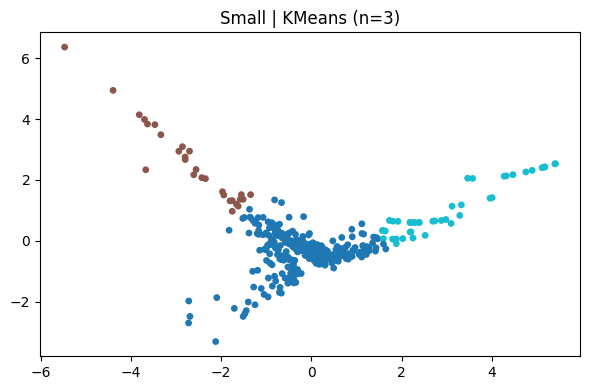

Группа: Medium — Метод: KMeans (n=3, score=0.795)


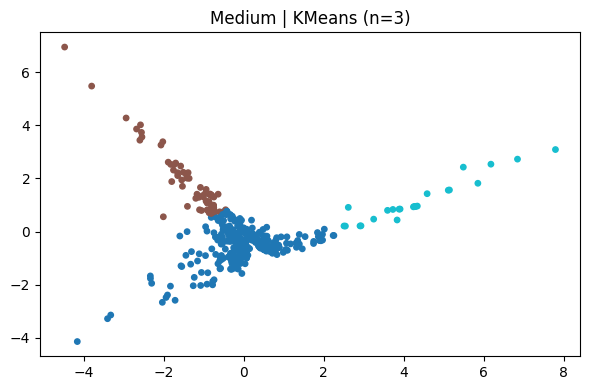

Группа: Large — Метод: KMeans (n=3, score=0.958)


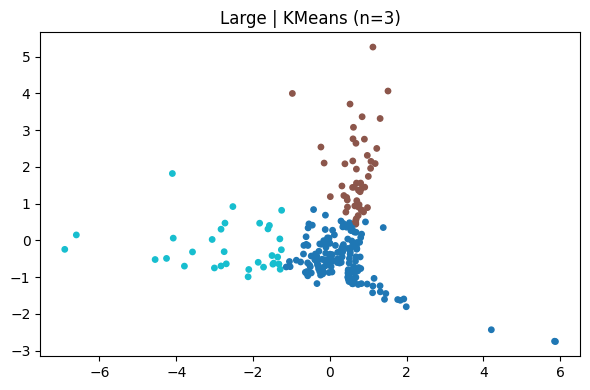

In [16]:
group_pca_data = {}

for group_name, best in best_results.items():
    print(f"Группа: {group_name.capitalize()} — Метод: {best['method']} (n={best['n']}, score={best['score']:.3f})")

    group_df = df[df['size_group'] == group_name].copy()
    
    group_X = group_df[features]
    group_X_scaled = scaler.fit_transform(group_X)

    labels = best['labels']


    # PCA для визуализации
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(group_X_scaled)

    
    group_pca_data[group_name] = {
        "X_pca": X_pca,
        "labels": labels,
        "df": group_df,
        "title": f"{group_name.capitalize()} | {best['method']} (n={best['n']})"
    }

    plot_clusters(X_pca, labels, title=group_pca_data[group_name]["title"])

C:\Users\Redmi\AppData\Local\Temp\ipykernel_472\3176989037.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = group_df.groupby('cluster').apply(lambda g: g.sample(min(len(g), 3), random_state=42)).reset_index(drop=True)


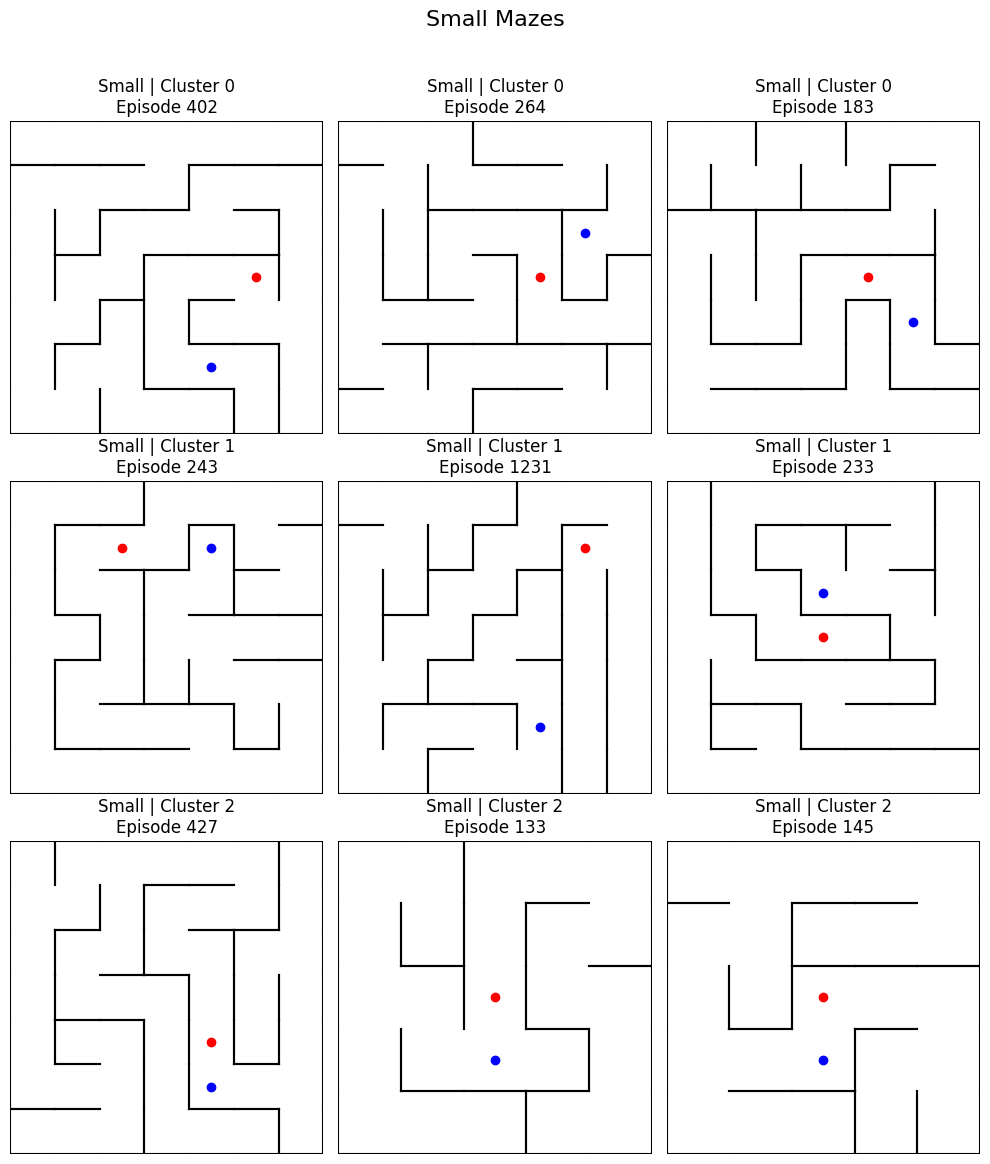

C:\Users\Redmi\AppData\Local\Temp\ipykernel_472\3176989037.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = group_df.groupby('cluster').apply(lambda g: g.sample(min(len(g), 3), random_state=42)).reset_index(drop=True)


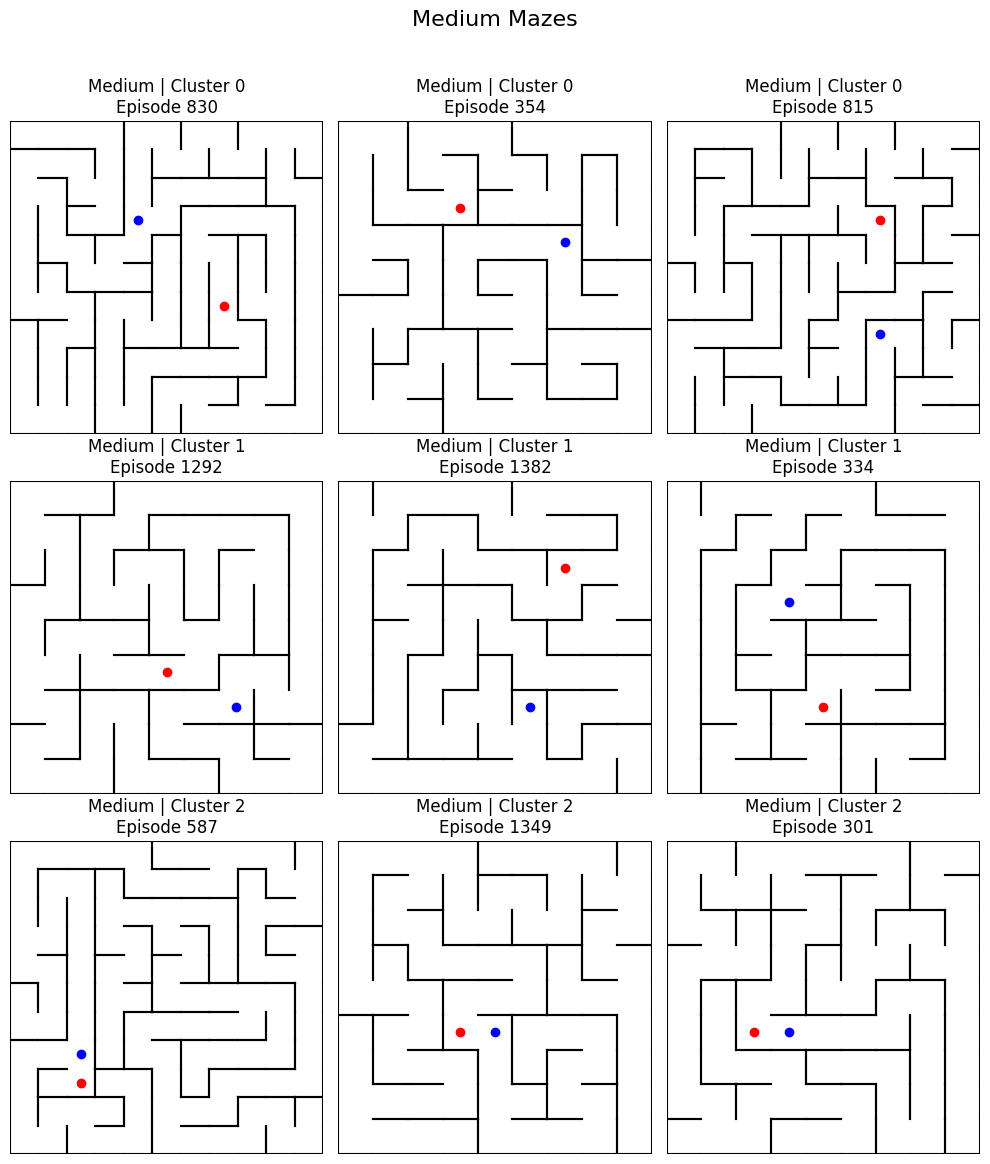

C:\Users\Redmi\AppData\Local\Temp\ipykernel_472\3176989037.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = group_df.groupby('cluster').apply(lambda g: g.sample(min(len(g), 3), random_state=42)).reset_index(drop=True)


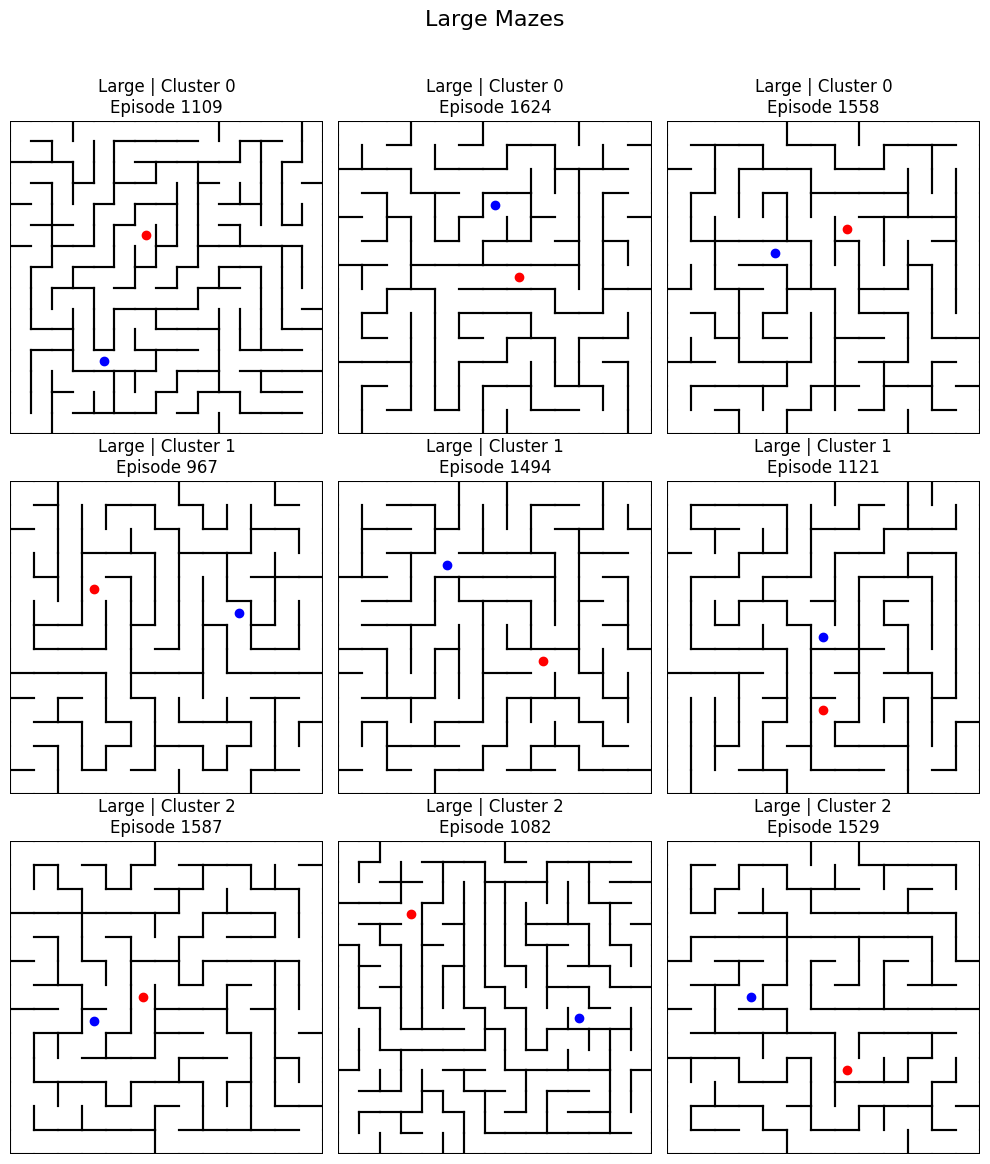

In [17]:
maze_dir = "Mazes"

def draw_maze(maze_data, ax):
    size = maze_data['mazeSize']

    for cell in maze_data['cells']:
        x, y = cell['x'], cell['y']
        if cell['top'] == 1:
            ax.plot([x, x + 1], [y + 1, y + 1], 'k')
        if cell['bottom'] == 1:
            ax.plot([x, x + 1], [y, y], 'k')
        if cell['left'] == 1:
            ax.plot([x, x], [y, y + 1], 'k')
        if cell['right'] == 1:
            ax.plot([x + 1, x + 1], [y, y + 1], 'k')

    agent_x = maze_data['agentStart']['x'] + 0.5 - 1
    agent_y = maze_data['agentStart']['y'] + 0.5 - 1
    target_x = maze_data['target']['x'] + 0.5 - 1
    target_y = maze_data['target']['y'] + 0.5 - 1

    ax.plot(agent_x, agent_y, 'bo')
    ax.plot(target_x, target_y, 'ro')

    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')



for group_name, data in group_pca_data.items():
    group_df = data["df"].copy()
    labels = data["labels"]

    group_df['cluster'] = labels

    
    samples = group_df.groupby('cluster').apply(lambda g: g.sample(min(len(g), 3), random_state=42)).reset_index(drop=True)
    num_clusters = samples['cluster'].nunique()

    
    fig, axs = plt.subplots(num_clusters, 3, figsize=(10, 4 * num_clusters))
    if num_clusters == 1:
        axs = np.expand_dims(axs, axis=0)

    
    for row_idx, cluster_id in enumerate(sorted(samples['cluster'].unique())):
        cluster_samples = samples[samples['cluster'] == cluster_id]
        for col_idx, row in enumerate(cluster_samples.itertuples()):
            ax = axs[row_idx, col_idx]
            episode_id = int(row.episode_id)
            file_path = os.path.join(maze_dir, f"maze_episode_{episode_id}.json")

            
            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    maze_data = json.load(f)
                draw_maze(maze_data, ax)
                ax.set_title(f"{group_name.capitalize()} | Cluster {cluster_id}\nEpisode {episode_id}")
            else:
                ax.axis('off')
                ax.set_title(f"Файл не найден\nEpisode {episode_id}")

        for col_idx in range(len(cluster_samples), 3):
            axs[row_idx, col_idx].axis('off')

    plt.suptitle(f"{group_name.capitalize()} Mazes", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [18]:
for group_name, group_data in group_pca_data.items():
    df_with_labels = group_data["df"].copy()
    df_with_labels["cluster"] = group_data["labels"]
    
    print(f"Группа: {group_name.capitalize()} — статистика по кластерам:")
    cluster_stats = df_with_labels.groupby("cluster")[features].agg(['mean', 'std', 'count']).round(2)
    
    display(cluster_stats)

Группа: Small — статистика по кластерам:


efficiency             reward_per_cell             distance_per_cell  \
              mean   std count            mean   std count              mean   
cluster                                                                        
0             0.04  0.14   306            0.04  0.15   306              1.30   
1            -0.00  0.02    28           -0.01  0.07    28              3.55   
2             0.69  0.30    43            0.62  0.26    43              0.95   

                    distance_traveled               
          std count              mean    std count  
cluster                                             
0        0.42   306             33.53  26.60   306  
1        1.56    28            159.77  74.27    28  
2        0.27    43              3.25   1.44    43

Группа: Medium — статистика по кластерам:


efficiency             reward_per_cell             distance_per_cell  \
              mean   std count            mean   std count              mean   
cluster                                                                        
0            -0.01  0.12   316           -0.02  0.13   316              1.43   
1            -0.00  0.01    65           -0.01  0.04    65              2.95   
2             0.66  0.24    24            0.58  0.22    24              0.91   

                    distance_traveled               
          std count              mean    std count  
cluster                                             
0        0.44   316             52.29  40.61   316  
1        1.19    65            207.10  89.03    65  
2        0.26    24              2.79   1.49    24

Группа: Large — статистика по кластерам:


efficiency             reward_per_cell             distance_per_cell  \
              mean   std count            mean   std count              mean   
cluster                                                                        
0             0.01  0.10   159            0.01  0.09   159              1.39   
1            -0.00  0.01    50           -0.02  0.04    50              2.61   
2            -0.25  0.18    32           -0.30  0.14    32              1.50   

                    distance_traveled               
          std count              mean    std count  
cluster                                             
0        0.42   159             61.20  42.52   159  
1        1.22    50            215.43  78.55    50  
2        0.70    32             10.36   5.89    32

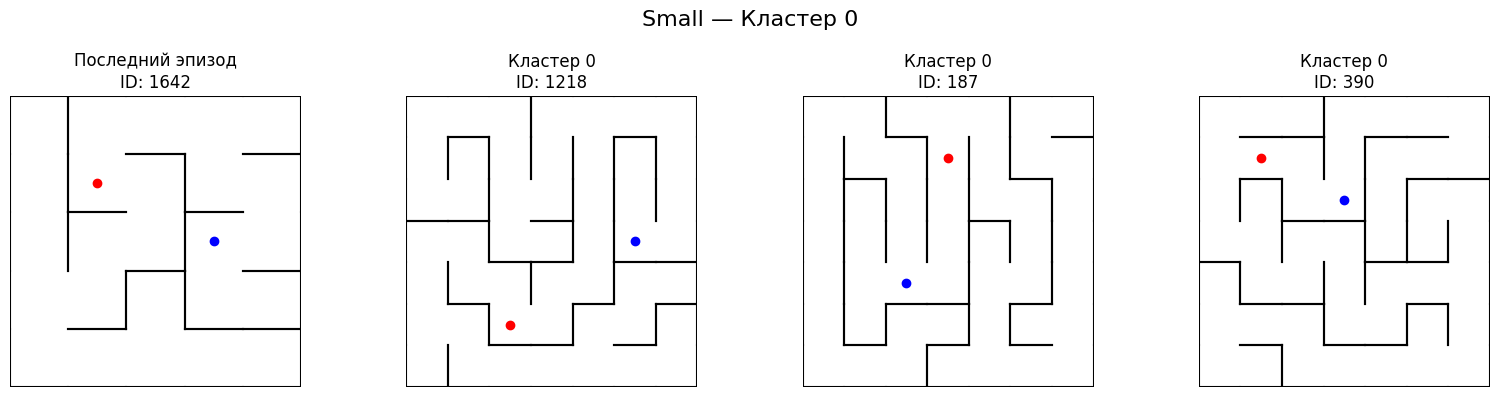

In [19]:
def draw_last_episode(group_name="medium", maze_dir="Mazes"):
    group_df = group_pca_data[group_name]["df"].copy()
    group_df['cluster'] = group_pca_data[group_name]["labels"]

    last_episode_row = group_df.loc[group_df['episode_id'].idxmax()]
    last_episode_id = int(last_episode_row['episode_id'])
    last_cluster_id = last_episode_row['cluster']

    same_cluster_df = group_df[
        (group_df['cluster'] == last_cluster_id) & 
        (group_df['episode_id'] != last_episode_id)
    ]
    sample_episodes = same_cluster_df.sample(min(3, len(same_cluster_df)))

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    last_path = os.path.join(maze_dir, f"maze_episode_{last_episode_id}.json")
    if os.path.exists(last_path):
        with open(last_path, 'r') as f:
            maze_data = json.load(f)
        draw_maze(maze_data, axs[0])
        axs[0].set_title(f"Последний эпизод\nID: {last_episode_id}")
    else:
        axs[0].axis('off')
        axs[0].set_title(f"Файл не найден\nID: {last_episode_id}")

    for i, row in enumerate(sample_episodes.itertuples(), start=1):
        sample_id = int(row.episode_id)
        sample_path = os.path.join(maze_dir, f"maze_episode_{sample_id}.json")
        if os.path.exists(sample_path):
            with open(sample_path, 'r') as f:
                maze_data = json.load(f)
            draw_maze(maze_data, axs[i])
            axs[i].set_title(f"Кластер {last_cluster_id}\nID: {sample_id}")
        else:
            axs[i].axis('off')
            axs[i].set_title(f"Файл не найден\nID: {sample_id}")

    plt.suptitle(f"{group_name.capitalize()} — Кластер {last_cluster_id}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


draw_last_episode("small")